# Ouray Raster Prep

Author: **Bryce A Young** | 
Created: **2024-12-06** | 
Modified: **2025-01-06**

In this notebook, I prepare rasters so that they are the proper CRS, extents, dtypes, nodata etc. for use in the Ouray analysis. These rasters are used in `hiz/ouray_hiz.ipynb` which can be found in this repository (`ouray`). 

#### Data 
- SILVIS Global WUI
- LiDAR-derived rasters
- Ouray County Boundary

#### Workflow 
1. Explore metadata of all the rasters. 
2. Create snap rasters and extent rasters from Ouray County boundary
    - 1m rasters
    - 10m rasters
3. Use extent rasters to ensure common raster sizes and extents
4. Reproject SILVIS rasters to match county rasters
5. Mosaic SILVIS rasters to create one single raster. 
6. Clip SILVIS raster to county boundary

## Step 1: Import rasters and explore metadata

In [4]:
import os
os.chdir('E:/_PROJECTS/Ouray_ParcelRisk/ouray')
print("Current working directory:", os.getcwd())

Current working directory: E:\_PROJECTS\Ouray_ParcelRisk\ouray


In [1]:
# Define frequently used path
data_path = 'E:/_PROJECTS/Ouray_ParcelRisk/data'

In [5]:
import rasterio as rio
import numpy as np
from utils.raster import read_raster

# Import two of the las rasters for comparison
zentropy, zentropy_profile = read_raster(f'{data_path}/tiffs_from_las/ouray_zentropy.tif', profile=True)
chm, chm_profile = read_raster(f'{data_path}/tiffs_from_las/ouray_chm.tif', profile=True)

# Import Global WUI rasters
wui1, wui1_prof = read_raster(f'{data_path}/silvis_wui/X0073_Y0064/WUI.tif', profile=True)
wui2, wui2_prof = read_raster(f'{data_path}/silvis_wui/X0073_Y0065/WUI.tif', profile=True)

# Compare profiles visually
print('zentropy: ', zentropy_profile)
print('chm: ', chm_profile)
print('wui1: ', wui1_prof)
print('wui2: ', wui2_prof)

zentropy:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 42881, 'height': 47000, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["NAD83(2011) / UTM zone 13N",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 236950.0,
       0.0, -1.0, 4247000.0), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
chm:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 42881, 'height': 47000, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["NAD83(2011) / UTM zone 13N",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 236950.0,
       0.0, -1.0, 4247000.0), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
wui1:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10000, 'height': 10000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["World Geodetic Sy

## Step 2: Mosaic WUI rasters
Get a single raster from the two WUI rasters.

Note that we're in a geographic coordinate system, dtype is uint8 and nodata is 255. We're not going to change any of this yet - just keep it in mind for now.

In [9]:
# Mosaic WUI rasters (wui1 and wui2, defined in above codeblock)
from utils.raster import mosaic_rasters
import rasterio as rio
import numpy as np

wui1_path = f'{data_path}/silvis_wui/X0073_Y0064/WUI.tif'
wui2_path = f'{data_path}/silvis_wui/X0073_Y0065/WUI.tif'

# Inputs
input_rasters = [wui1_path, wui2_path]
output_raster = os.path.join(data_path, 'silvis_wui/wui.tif')

# Run function
mosaic_rasters(input_rasters, output_raster)

Mosaic written to E:/_PROJECTS/Ouray_ParcelRisk/data\silvis_wui/wui.tif


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10000, 'height': 20000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",-97.5],PARAMETER["false_easting",8264722.17686],PARAMETER["false_northing",4867518.35323],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(10.0, 0.0, 7300000.0,
       0.0, -10.0, 3500000.0), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


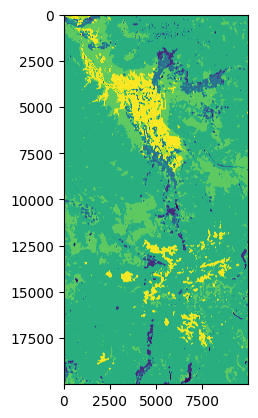

In [10]:
from utils.raster import read_raster
import matplotlib.pyplot as plt

wui, wui_profile = read_raster(output_raster, layer=1, profile=True)
print(wui_profile)
plt.imshow(wui)

## Step 3: Create rasterized county boundary

Now we want to clip these rasters to the extent of the county boundary, matching the shape and the CRS.

In [11]:
# Import county shapefile
import geopandas as gpd

# Path to shapefile
county_boundary = os.path.join(data_path, 'county_boundary')

county_shp = gpd.read_file(os.path.join(county_boundary, 'Ouray_County_Boundary.shp'))
county_shp.crs # Check CRS

<Projected CRS: PROJCS["NAD83_Conus_Albers",GEOGCS["GCS_NAD83",DAT ...>
Name: NAD83_Conus_Albers
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

We need to rasterize the county shapefile into a binary raster where 1 = values inside the county and 0 = values outside the county.

Make a raster at 10m for silvis wui and a raster at 1m for the lidar rasters.

We're going to use the local CRS for all rasters and shapefiles. The LiDAR rasters are all on the local CRS, so we can use that CRS to reproject the county boundary and the WUI raster.

In [19]:
import geopandas as gpd

# Reproject county boundary
county_shp = county_shp.to_crs('EPSG:26913') # Local CRS: NAD83 / UTM zone 13N
county_shp.crs

<Projected CRS: EPSG:26913>
Name: NAD83 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 108°W and 102°W - onshore and offshore. Canada - Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Colorado; Montana; Nebraska; New Mexico; North Dakota; Oklahoma; South Dakota; Texas; Wyoming.
- bounds: (-108.0, 28.98, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
import rasterio as rio
from rasterio.features import rasterize
import numpy as np
from utils.raster import rast_and_write

# Rasterize and write raster to file
county_boundary_raster = rast_and_write(county_shp, 
                                        os.path.join(data_path, 'county_boundary/county_raster.tif'), 
                                        profile=zentropy_profile,
                                        dtype='uint8',
                                        crs=county_shp.crs
                                       )
                                        

NameError: name 'raster_profile' is not defined